# Data Exploration

## Connect to Workspace

In [1]:
import azureml.core
from azureml.core import Workspace

In [2]:
# Here we load a workspace from a saved config file
ws = Workspace.from_config()
print('Azure ML {} has loaded in the {} workspace.'.format(azureml.core.VERSION, ws.name))

Azure ML 1.48.0 has loaded in the andreiroibu-mlworkspace workspace.


In [3]:
# Explore the data
import pandas as pd

df = pd.read_csv('datasets/diabetes.csv')
print(df.head())

   PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  
0                34            23  43.509726          1.213191   21         0  
1                47            36  21.240576          0.158365   23         0  
2                52            35  41.511523          0.079019   23         0  
3                25           304  29.582192          1.282870   43         1  
4                27            35  42.604536          0.549542   22         0  


## Create an experimental folder

In [4]:
import os, shutil

# Make the experiment folder
folderName = 'DiabetesDataExploration'
experimentFolder = './' + folderName
os.makedirs(folderName, exist_ok=True)
# Copy the data file into the experiment folder
shutil.copy('datasets/diabetes.csv', os.path.join(folderName, 'diabetes.csv'))


'DiabetesDataExploration/diabetes.csv'

In [5]:
%%writefile $folderName/diabetesDataExploration.py
from azure.core import Run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the experimental context
run = Run.get_context()

df = pd.read_csv('datasets/diabetes.csv')

# Log the number of rows
rowCount = len(df)
run.log('no_observations', rowCount)

# Log the summary statistics for numeric columns
medicalColumns = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'Age' ]

summaryStatistics = df[medicalColumns].describe().to_dict()
for col in summaryStatistics:
    keys = list(summaryStatistics[col].keys())
    values = list(summaryStatistics[col].values())
    for idx in range(len(keys)):
        run.log_row(col, stat=keys[idx], values=values[idx])

# Log distinct pregnancy counts
pregnancies = df.Pregnancies.unique()
run.log_list('Pregnancy Categories', pregnancies)

# Count and Log Diabetic Lables
labels = df['Diabetic'].value_counts()
for key, value in labels:
    run.log('Label:' + str(key), value)

# Plot and log the distribution of diabetic vs non-diabetic
diabeticCounts = df['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabeticCounts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name='label distribution', plot=fig)

# Save a sample of the data
df.sample(100).to_csv('diabetesSample.csv', index=False, header=True)
run.upload_file(name='outputs/diabetesSample.csv', path_or_stream='./diabetesSample.csv')

run.complete()

Overwriting DiabetesDataExploration/diabetesDataExploration.py


## Run an Experiment

Here we will run an AzureML experiment performing basic data analysis. Azure Experiment will enable the logging of run details. 

In [6]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import DockerConfiguration
from azureml.widgets import RunDetails

# Create a Python environment for the experiment (from a .yml file)
env = Environment.from_conda_specification('expEnv', 'environment.yml')

# Create the ScriptConfig that identifies the Python Script to be ran
scriptConfig = ScriptRunConfig(source_directory=experimentFolder,
                                script='diabetesDataExploration.py',
                                environment=env,
                                docker_runtime_config=DockerConfiguration(use_docker=True)
                                )
# Submit the experiment
experiment = Experiment(workspace=ws, name='andreiroibu-diabetes')
run = experiment.submit(config=scriptConfig)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [3]:
# from azureml.core import Experiment
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

In [20]:
# # Create an AzureML experiment
# experiment = Experiment(workspace=ws, name='andreiroibu-diabetes')

# # Load the data
# df = pd.read_csv('datasets/diabetes.csv')
# print(df.head())

   PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  
0                34            23  43.509726          1.213191   21         0  
1                47            36  21.240576          0.158365   23         0  
2                52            35  41.511523          0.079019   23         0  
3                25           304  29.582192          1.282870   43         1  
4                27            35  42.604536          0.549542   22         0  


Starting Experiment andreiroibu-diabetes


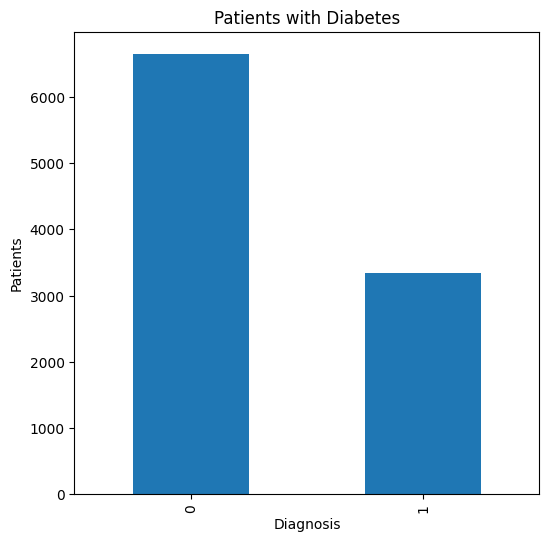

In [26]:
# # Star a logging data session from the experiment
# run = experiment.start_logging()
# print("Starting Experiment {}".format(experiment.name))

# # Log the number of rows
# rowCount = len(df)
# run.log('no_observations', rowCount)

# # Log the summary statistics for numeric columns
# medicalColumns = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
#        'TricepsThickness', 'SerumInsulin', 'BMI', 'Age' ]

# summaryStatistics = df[medicalColumns].describe().to_dict()
# for col in summaryStatistics:
#     keys = list(summaryStatistics[col].keys())
#     values = list(summaryStatistics[col].values())
#     for idx in range(len(keys)):
#         run.log_row(col, stat=keys[idx], values=values[idx])

# # log distinct pregnancy counts
# pregnancies = df.Pregnancies.unique()
# run.log_list('Pregnancy Categories', pregnancies)

# # Plot and log the distribution of diabetic vs non-diabetic
# diabeticCounts = df['Diabetic'].value_counts()
# fig = plt.figure(figsize=(6,6))
# ax = fig.gca()    
# diabeticCounts.plot.bar(ax = ax) 
# ax.set_title('Patients with Diabetes') 
# ax.set_xlabel('Diagnosis') 
# ax.set_ylabel('Patients')
# plt.show()
# run.log_image(name='label distribution', plot=fig)

# # Save a sample of the data
# df.sample(100).to_csv('diabetesSample.csv', index=False, header=True)
# run.upload_file(name='outputs/diabetesSample.csv', path_or_stream='./diabetesSample.csv')

# # Complete the run
# run.complete()

## View Run Details

The above results can either be visualised in the ***Jobs > (job name)*** run details area, or can be interogated using the SDK.

In [27]:
# from azureml.widgets import RunDetails
# RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

KeyError: 'log_files'

KeyError: 'log_files'

KeyError: 'log_files'

In [29]:
import json
print('Metrics:')
metrics = run.get_metrics()
for metricName in metrics:
    print(metricName, '-', metrics[metricName])
    print('---')

print('\n')
print('Files')
files = run.get_file_names()
for file in files:
    print(file)

Metrics:
BMI - {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'values': [10000.0, 31.56702174359113, 9.804365693559113, 18.20080735, 21.247426835, 31.922420785, 39.3289214475, 56.03462763]}
---
no_observations - 10000
---
Age - {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'values': [10000.0, 30.1341, 12.106046952960462, 21.0, 22.0, 24.0, 35.0, 77.0]}
---
Pregnancies - {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'values': [10000.0, 3.2558, 3.4057196379950074, 0.0, 0.0, 2.0, 6.0, 14.0]}
---
Pregnancy Categories - [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
---
PlasmaGlucose - {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'values': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
---
label distribution - aml://artifactId/ExperimentRun/dcid.0c6d9f05-e86c-4179-b024-7a36b747af6d/label distribution_1676829248.png
---
DiastolicBloodPressure - {'stat': ['count', 'mea

In [32]:
# To download files:

import os
downloadFolder = 'downloadedFiles'
run.download_files(prefix='outputs', output_directory=downloadFolder)
for root, directory, filenames in os.walk(downloadFolder):
    for filename in filenames:
        print (os.path.join(root,filename))

downloadedFiles/outputs/diabetesSample.csv


In [30]:
run.get_details_with_logs() # This can be useful for troubleshooting!

{'runId': '0c6d9f05-e86c-4179-b024-7a36b747af6d',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2023-02-19T17:54:05.759454Z',
 'endTimeUtc': '2023-02-19T17:54:14.526171Z',
 'services': {},
 'properties': {'azureml.git.repository_uri': 'https://github.com/AndreiRoibu/AzureMachineLearning.git',
  'mlflow.source.git.repoURL': 'https://github.com/AndreiRoibu/AzureMachineLearning.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9dc35540e3400103c401c207864eb19d17adf017',
  'mlflow.source.git.commit': '9dc35540e3400103c401c207864eb19d17adf017',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '55585d8a-a866-4efa-93d6-86a7147df50a'},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {},
 'submittedBy': 'Andrei-Claudiu Roibu'}